# Task 1.1 [z] - Next value prediction

> Luca Laboccetta,  
> Giorgio Andronico 

## Data understanding

### Initial data collection

Boilerplate code: importing useful modules, choosing compute backend, mounting Google Drive

In [1]:
import keras
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils.vis_utils import plot_model
from google.colab import drive
import tensorflow as tf
!pip install -q -U keras-tuner
import keras_tuner as kt

# Choose computing backend
computing_resource = tf.test.gpu_device_name()
if "GPU" not in computing_resource:
  computing_resource = "/CPU:0"
print(f"Computing resource: {computing_resource}")

# Mount Google Drive
drive.mount('/content/drive')

# Setting seed for reproducibility
seed = 44
np.random.seed(seed)
tf.random.set_seed(seed)

     |████████████████████████████████| 135 kB 4.4 MB/s 
     |████████████████████████████████| 1.6 MB 9.0 MB/s 
Computing resource: /device:GPU:0
Mounted at /content/drive


Load *Healthware* dataset, both train and test. Loading *z* column only, as this notebook focuses only on analyzing this column

In [2]:
train = pd.read_csv("/content/drive/MyDrive/DeepLearning/Datasets/Progetto/train.csv").drop('x', 1).drop('y', 1)
test_set = pd.read_csv("/content/drive/MyDrive/DeepLearning/Datasets/Progetto/test.csv").drop('x', 1).drop('y', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


### Data exploration

Datasets' shapes

In [3]:
print("Train dataset shape:")
print(train.shape)
print("Test dataset shape:")
print(test_set.shape)

Train dataset shape:
(144911, 1)
Test dataset shape:
(148371, 1)


Statistical quantities for each column

In [4]:
train.describe()

,z
count,144911.000000
mean,-307.588768
std,538.335654
min,-1001.000000
25%,-794.000000
50%,-416.000000
75%,83.000000
max,1032.000000


Object types (this is useful to see how *pandas* parsed the .csv file)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144911 entries, 0 to 144910
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   z       144911 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


#### Data visualization

The y-axis depicts the value of the single instance, while the x-axis is merely the row index of that instance.

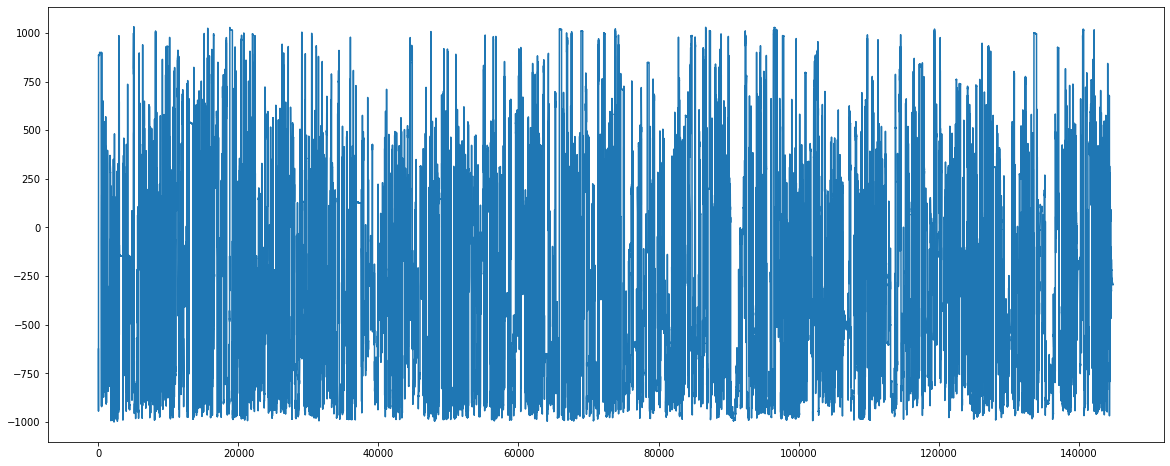

In [6]:
fig = plt.figure(figsize=(20, 8))
plt.plot(train)

## Data preparation

#### Normalization and splitting

Normalizing train data in a -1:1 range

In [7]:
mean = train.mean()
std = train.std()
train = (train - mean) / std
train

,z
0,-0.591473
1,0.454343
2,-0.500452
3,-0.463301
4,-0.164231
...,...
144906,0.025242
144907,0.025242
144908,0.023385
144909,0.025242


Normalizing test data in a -1:1 range

In [8]:
mean = test_set.mean()
std = test_set.std()
test_set = (test_set - mean) / std
test_set

,z
0,1.067465
1,1.065257
2,0.778299
3,0.577429
4,0.592880
...,...
148366,1.142515
148367,1.142515
148368,1.142515
148369,1.142515


Creation of the validation set, extracting 30% of the training set

In [9]:
n_rows_train = round(len(train)*0.7)
train_set = train[:n_rows_train]
validation_set = train[n_rows_train:]
validation_set.index = np.arange(0, len(validation_set))
validation_set

,z
0,0.305736
1,0.287161
2,0.424621
3,1.000470
4,0.688397
...,...
43468,0.025242
43469,0.025242
43470,0.023385
43471,0.025242


#### Labeling the dataset

Defining the windowing function

In [10]:
def generate_windows(df, window_size, window_shift):
    windows = []
    labels = []

    for i in range(0, len(df), window_shift):
        if (i + window_size >= len(df)):
            break

        windows.append(df[i: i + window_size])
        labels.append(df.iloc[i + window_size])
    
    return np.array(windows, dtype=np.float32), np.array(labels, dtype=np.float32)

Windowing the dataset

In [11]:
window_size = 30
window_shift = 6

X_train, y_train = generate_windows(train_set, window_size, window_shift)
X_val, y_val = generate_windows(validation_set, window_size, window_shift)
X_test, y_test = generate_windows(test_set, window_size, window_shift)

## Modeling



### Hyperparameter search

Defining model skeleton and search ranges for each hyperparameter

In [12]:
def build_model(hp):
  model = Sequential()
  LSTM_1_units = hp.Int('LSTM_1_units', min_value=16, max_value=128, step=16)
  dropout_rate = 0.1

  # return_sequences=True needed to chain second LSTM!
  model.add(LSTM(LSTM_1_units,
                 input_shape=(window_size, X_train.shape[2])))
  model.add(Dense(1))

  lr_choices = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_choices), loss='mae')
  return model

Instantiating of the tuner on the model skeleton defined above. Definition of early stopping criteria.

In [13]:
tuner = kt.Hyperband(build_model, objective='val_loss', max_epochs=50, seed=seed)
# If val_loss does not improve in five epochs straight, stop training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Searching for the best hyperparameters

In [14]:
with tf.device(computing_resource):
    tuner.search(np.array(X_train), 
                np.array(y_train), 
                validation_data=(X_val, y_val), 
                callbacks=[early_stop])

Trial 24 Complete [00h 00m 08s]
val_loss: 0.10405935347080231

Best val_loss So Far: 0.09956143796443939
Total elapsed time: 00h 04m 20s


Printing the best parameters found

In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first LSTM is {best_hps.get('LSTM_1_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first LSTM is 64.
The optimal learning rate for the optimizer is 0.001.



### Fitting and building

Building the model with the best hyperparameters found above

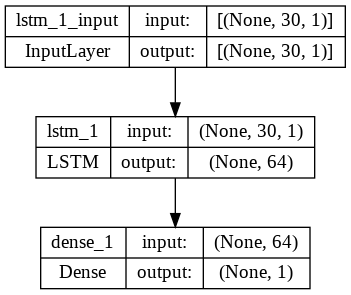

In [16]:
model = tuner.hypermodel.build(best_hps)
plot_model(model, show_shapes=True, show_layer_names=True)

Compiling and training the model on these parameters

In [17]:
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(
                  learning_rate=best_hps.get('learning_rate')))
with tf.device(computing_resource):
    history = model.fit(X_train,
                        y_train, 
                        epochs=150, 
                        validation_data=(X_val, y_val))

Epoch 1/150
529/529 [==============================] - 5s 6ms/step - loss: 0.1771 - val_loss: 0.1246
Epoch 2/150
529/529 [==============================] - 3s 5ms/step - loss: 0.1234 - val_loss: 0.1074
Epoch 3/150
529/529 [==============================] - 3s 5ms/step - loss: 0.1188 - val_loss: 0.1041
Epoch 4/150
529/529 [==============================] - 3s 5ms/step - loss: 0.1172 - val_loss: 0.0995
Epoch 5/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1171 - val_loss: 0.0990
Epoch 6/150
529/529 [==============================] - 3s 5ms/step - loss: 0.1170 - val_loss: 0.1008
Epoch 7/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1165 - val_loss: 0.1015
Epoch 8/150
529/529 [==============================] - 3s 5ms/step - loss: 0.1167 - val_loss: 0.0994
Epoch 9/150
529/529 [==============================] - 3s 6ms/step - loss: 0.1160 - val_loss: 0.0991
Epoch 10/150
529/529 [==============================] - 3s 5ms/step - loss: 0.1163 - val_lo

Taking the epoch where metrics have been best and re-training the model only for that number of epochs

In [18]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f'Epoch with lowest validation loss: {best_epoch}')

hypermodel_best_epoch = tuner.hypermodel.build(best_hps)
with tf.device(computing_resource):
    history = hypermodel_best_epoch.fit(X_train, 
                                        y_train, 
                                        epochs=best_epoch, 
                                        validation_data=(X_val, y_val))

Epoch with lowest validation loss: 23
Epoch 1/23
529/529 [==============================] - 5s 6ms/step - loss: 0.1816 - val_loss: 0.1187
Epoch 2/23
529/529 [==============================] - 3s 5ms/step - loss: 0.1240 - val_loss: 0.1032
Epoch 3/23
529/529 [==============================] - 3s 5ms/step - loss: 0.1182 - val_loss: 0.1002
Epoch 4/23
529/529 [==============================] - 3s 5ms/step - loss: 0.1176 - val_loss: 0.0987
Epoch 5/23
529/529 [==============================] - 3s 5ms/step - loss: 0.1173 - val_loss: 0.0994
Epoch 6/23
529/529 [==============================] - 3s 5ms/step - loss: 0.1169 - val_loss: 0.0989
Epoch 7/23
529/529 [==============================] - 3s 5ms/step - loss: 0.1168 - val_loss: 0.1017
Epoch 8/23
529/529 [==============================] - 3s 5ms/step - loss: 0.1167 - val_loss: 0.1024
Epoch 9/23
529/529 [==============================] - 3s 5ms/step - loss: 0.1161 - val_loss: 0.0997
Epoch 10/23
529/529 [==============================] - 3s 5ms/

## Evaluation

### Metrics

The plot shows a gradual decrease in both training and validation loss, with validation steadily staying below training. No sign of overfitting. The x-axis depicts the epoch, while the y-axis depicts the loss value for that epoch.

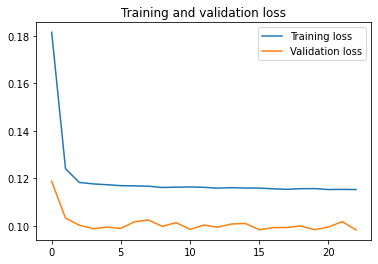

In [19]:
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(len(loss))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predictions

Creating predictions from the test set

In [20]:
pred_test = hypermodel_best_epoch.predict(X_test)

773/773 [==============================] - 2s 2ms/step


Evaluating accuracy of the predictions

In [21]:
denormalized_predictions = (pred_test * std['z']) + mean['z']
denormalized_original_values = (y_test * std['z']) + mean['z']
mae_test = mean_absolute_error(denormalized_original_values, denormalized_predictions)
print(f'MAE for variable Z: {mae_test}')

MAE for variable Z: 73.06783294677734
